In [2]:
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot

from utils import *


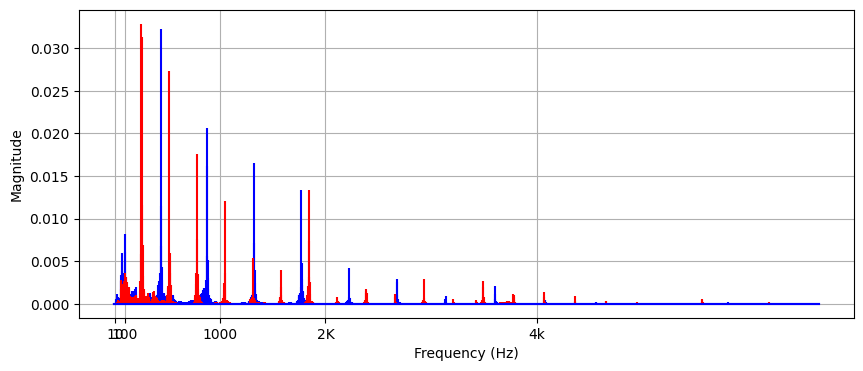

In [190]:
# Create 440Hz (A4) and 1046.5 (C5) sine waves

sr = 44100
duration = 0.3
frames = np.arange(duration * sr) / sr

smooth_len = 1000
smoothing = np.linspace(0, 1, smooth_len)

A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)

A_fft = np.fft.fft(A_signal)
C_fft = np.fft.fft(C_signal)
n = len(A_signal)
frequency = np.fft.fftfreq(n, d=1/sr)
frequency = frequency[:len(frequency) // 2]

# Take the magnitude of the FFT and normalize it
A_magnitude = np.abs(A_fft)
A_magnitude /= np.sum(A_magnitude)
C_magnitude = np.abs(C_fft)
C_magnitude /= np.sum(C_magnitude)


index = 2000

# Plot the frequency spectrum
plt.figure(figsize=[10, 4])
plt.stem(frequency[:index], A_magnitude[:index], 'b', markerfmt=" ", basefmt="-b")
plt.stem(frequency[:index], C_magnitude[:index], 'r', markerfmt=" ", basefmt="-b")
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
# plt.xscale('log')
plt.xticks([10, 100, 1000, 2000, 4000], ['10', '100', '1000', '2K', '4k'])
plt.grid(True)
plt.show()

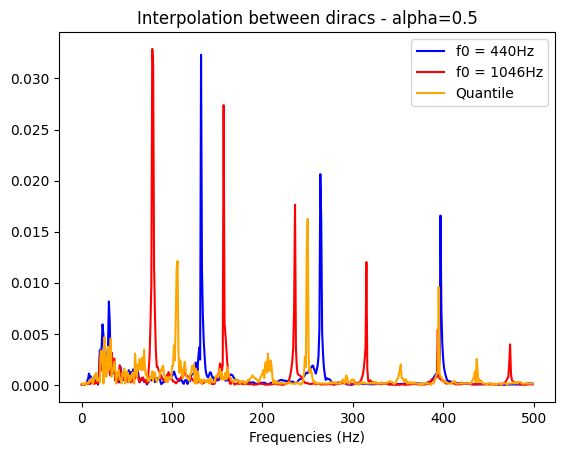

In [183]:
# Optimal transport

alpha = 0.5

# Quantile method 

quantile_interpolation = quantile_optimal_transport(A_magnitude, C_magnitude, alpha=alpha)
quantile_interpolation = np.pad(quantile_interpolation,(0, len(A_signal) - len(quantile_interpolation)))
quantile_interpolation /= np.sum(quantile_interpolation)

index = 1000
plt.plot(np.arange(sr/2)[:500], A_magnitude[:500], label=f"f0 = {A_freq:.0f}Hz", color="blue")
plt.plot(np.arange(sr/2)[:500], C_magnitude[:500], label=f"f0 = {C_freq:.0f}Hz", color="red")
plt.plot(np.arange(sr/2)[:500], quantile_interpolation[:500], label='Quantile', color="orange")
plt.xlabel("Frequencies (Hz)")
plt.title(f"Interpolation between diracs - alpha={alpha}")
plt.legend()
plt.show()


MovieWriter ffmpeg unavailable; using Pillow instead.


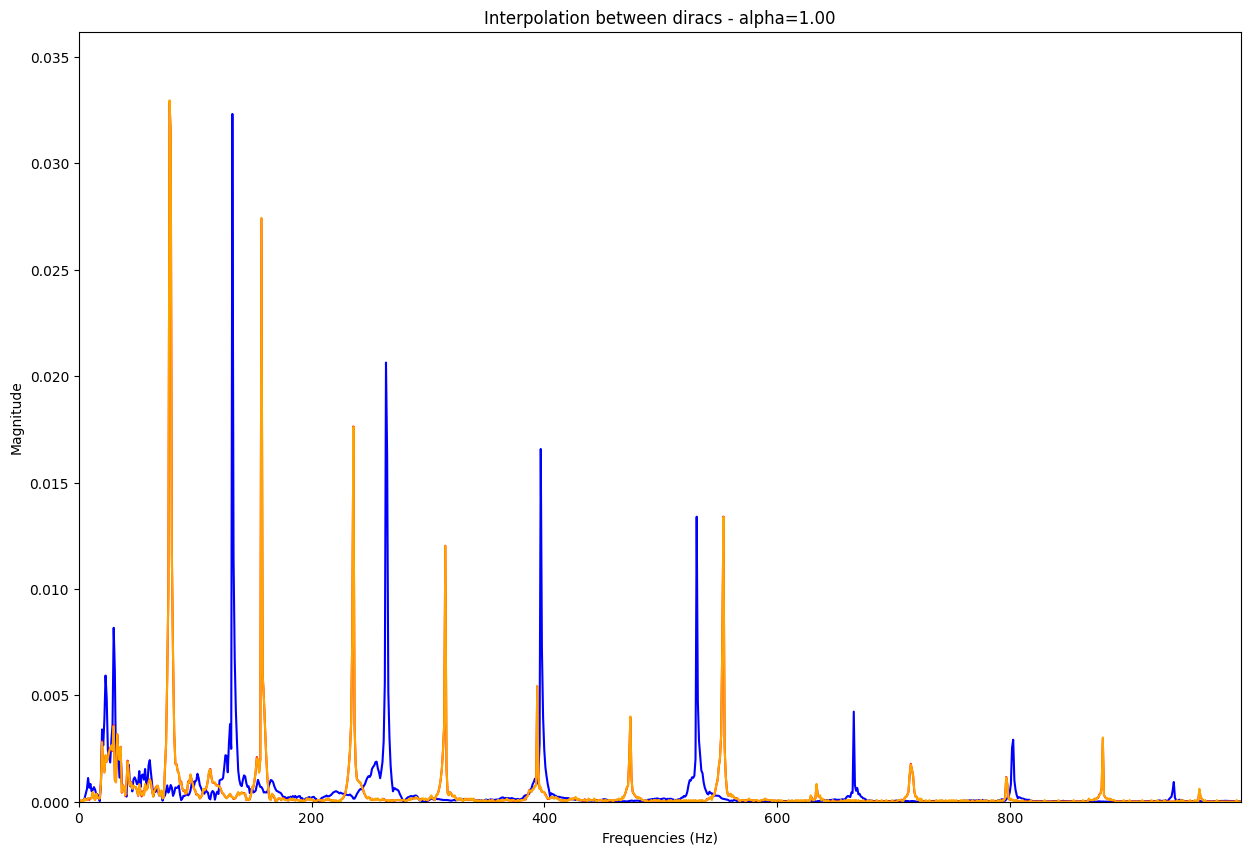

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

index = 1000
A_magnitude_index = A_magnitude[:index]
C_magnitude_index = C_magnitude[:index]

fig, ax = plt.subplots(figsize=(15,10))
ax.set(xlabel='Frequencies (Hz)', ylabel='Magnitude', title='Interpolation between diracs')

line_a, = ax.plot(np.arange(len(A_magnitude[:index])), A_magnitude[:index], 'blue', label='A_magnitude')
line_c, = ax.plot(np.arange(len(C_magnitude[:index])), C_magnitude[:index], 'red', label='C_magnitude')
line_quantile, = ax.plot([], [], 'orange', label='Quantile')

def init():
    ax.set_xlim(0, len(A_magnitude[:index])-1)  # Adjust based on your frequency range
    ax.set_ylim(0, max(np.max(A_magnitude[:index]), np.max(C_magnitude[:index])) * 1.1)  # Adjust based on your magnitude range
    line_quantile.set_data([], [])
    return line_a, line_c, line_quantile,

# Animation update function: this is called sequentially with the frame number
def update(alpha):
    # Recompute the quantile optimal transport for the current alpha
    quantile_interpolation = quantile_optimal_transport(A_magnitude, C_magnitude, alpha)
    # Update the data of the quantile plot line
    line_quantile.set_data(np.arange(len(quantile_interpolation[:index])), quantile_interpolation[:index])
    ax.set_title(f'Interpolation between diracs - alpha={alpha:.2f}')
    return line_a, line_c, line_quantile,

# Create animation
# np.linspace(0, 1, 101) generates 101 values from 0 to 1, adjust as needed for smoothness vs. speed
ani = FuncAnimation(fig, update, frames=np.linspace(0, 1, 101), init_func=init, blit=True)

ani.save('animation.gif')


In [186]:
a = np.fft.ifft(quantile_interpolation)
audio_widgets = []

title = widgets.Label(f'Quantile interpolation - alpha={0.5}')

audio_player = IPython.display.Audio(data=a, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid

e:\Dauphine\Cours\Mémoire\audio_1D_transport\.venv\lib\site-packages\IPython\lib\display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)
